In [3]:
%matplotlib inline
import emcee
import time
import numpy as np
import scipy.optimize as op
import matplotlib.pyplot as pl
import scipy.integrate as integrate
import scipy.linalg as linalg
from multiprocessing.pool import ThreadPool
from getdist import plots, MCSamples, loadMCSamples, types
from scipy.special import gamma
from scipy.integrate import quad

global argsortz #array de indices de zsni ordenados

import os
os.environ["OMP_NUM_THREADS"] = "1"

np.random.seed(321)

### Data

In [2]:
#32 H(z) data
filename = 'data/Hz32Clocks.txt'
zhzi, hzi, shzi = np.genfromtxt(filename, comments='#', usecols=(0,1,2), unpack=True)

#Covariance data
filename = 'data/data_MM20.dat'
zmod, imf, slib, sps, spsooo = np.genfromtxt(filename, comments='#', usecols=(0,1,2,3,4), unpack=True)

#number of data
ndata = len(zhzi)

### Some default configurations

In [3]:
pl.rcParams['text.usetex'] = True
priorArray = np.array([[50., 100.], [0.0, 3.0], [-3.0, 3.0], [0.1, 2]])
nstepHz = 20000

### Analysis functions

In [4]:
#Function to identify which model will be used
def free_par(theta, freef, flat):
    if freef == True:
        if flat == False:
            h0, wm, wl, f = theta
            return [h0, wm, wl, f]
        elif flat == True:
            h0, wm, f = theta
            return [h0, wm, 1-wm, f]
        else:
            print("Invalid flatness...")
            return None
    elif freef == False:
        if flat == False:
            h0, wm, wl = theta
            return [h0, wm, wl, 1]
        elif flat == True:
            h0, wm = theta
            return [h0, wm, 1-wm, 1]
        else:
            print("Invalid flatness...")
            return None
    else:
        print("Invalid correction parameter...")
        return None

#Calculate chi2 for the model
def chi2Hz(par):
    E2 = par[1]*(1+zhzi)**3+(1-par[1]-par[2])*(1+zhzi)**2+par[2]

    if np.any(E2<0):
        return np.inf

    Hzm = par[0]*np.sqrt(E2)
    dhz = hzi-Hzm
    inv_covCorr = inv_cov/par[3]**2

    return np.dot(np.dot(dhz.T, inv_covCorr), dhz)

#Check if parameters are in prior interval
def lnpriorHz(par):
    for i in range(len(par)):
        if not priorArray[i][0] < par[i] < priorArray[i][1]:
            return -np.inf
    return 0.0

#Calculate the likelihood
def lnlikeHz(par):
    chi2 = chi2Hz(par)
    return -0.5*chi2 - ndata*np.log(par[3])

def lnlikeHzA(par):
    chi2 = chi2Hz(par)
    return -0.5*chi2 - ndata*np.log(par[3])


def lnprobHz(theta, freef, flat):
    par = free_par(theta, freef, flat)
    
    lp = lnpriorHz(par)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlikeHz(par)

#Minimize chi2
def find_bestfit(lnlike, par_ml, parnames, freef, flat):
    t1 = time.time()
    ndim = len(par_ml)
    chi2 = lambda par_ml, freef, flat: -2*lnlike(par_ml, freef, flat)
    result = op.minimize(chi2, par_ml, args=(freef, flat))
    if not result['success']:
        result = op.minimize(chi2, par_ml, args=(freef, flat), method='Nelder-Mead', options={'maxiter': 10000})
    par_ml = result['x']
    print('Maximum likelihood result:')
    for i in range(ndim):
        print(parnames[i],' = ',par_ml[i])
    print('chi2min =',result['fun'])
    t2 = time.time()
    print('Total time: {0:5.3f} seg'.format(t2-t1))
    return result

#Run MC
def run_emcee(par_ml, nwalkers, lnprob, freef, flat, ainput, nsteps):
    ndim = len(par_ml)
    pos = [par_ml +1e-4*np.random.randn(ndim) for i in range(nwalkers)]
    
    with ThreadPool() as pool:
        sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[freef, flat], a=ainput, pool=pool)
        sampler.run_mcmc(pos, nsteps, progress=True)
    
    accept = sampler.acceptance_fraction
    print('Acceptance fraction:',accept)
    print('Minimum acceptance:',np.amin(accept))
    print('Maximum acceptance:',np.amax(accept))
    
    return sampler

#Remove burn in
def tira_burnin(sampler, burnin, ndim):
    samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))
    return samples


def burninthin(sampler, tau):
    taumax = np.amax(tau)
    taumin = np.amin(tau)
    samples = sampler.get_chain(discard=int(2*taumax), thin=int(taumin/2), flat=True)
    print(samples.shape)
    return samples

#MC results
def MC_result(samples, par_ml, parnames):
    ndim = len(par_ml)
    par_mean = np.mean(samples,axis=0)
    par_median = np.percentile(samples, [50], axis=0)[0]
    par_valm = np.percentile(samples, [15.865], axis=0)[0]
    par_valp = np.percentile(samples, [84.135], axis=0)[0]
    par_sigm = par_mean - par_valm
    par_sigp = par_valp - par_mean
    print('MCMC result:')
    for i in range(ndim):
        print("""{0} = {1:5.5f} +{2:5.5f} -{3:5.5f} (median: {4:5.5f}, ml: {5:5.5f})"""\
              .format(parnames[i],par_mean[i],par_sigp[i],par_sigm[i],par_median[i],par_ml[i]))

#Insert a derived paramater
def insertDerived(sample, parnames, parlabel, num, gsample, derived, derivedName, derivedLabel):
    n = np.zeros(num)
    
    if derivedName not in parnames:
        newSample = np.c_[sample, derived]
        parnames.append(derivedName)
        gsample.addDerived(derived, name=derivedName, label=derivedLabel)
        
        return newSample, gsample, parnames, n

    elif derivedName in parnames:
        print('Parâmetro dependente já adicionado.')

        return sample, gsample, parnames, n

#Distribution funcion for chi2
def chiDist(chi, n):
    return (n**(n/2)*((chi)**((n-2)/2))*np.exp(-(n/2)*chi))/(2**(n/2)*gamma(n/2))

#Calculate cdf for chiDist
def chiCDF(x, n):
    res = np.zeros_like(x)
    for i, val in enumerate(x):
        y, err = quad(chiDist, 0, val, args=(n))
        res[i]=y
    return res

#Plot chi2 cdf
def plotChiDist(chimin, par, name=0):
    n = ndata - par
    chi = np.linspace(0, 2.5, 500)
    chiv = np.full((500), chimin/n)
    hv = chiDist(chi, n)
    cdf = chiCDF(chi, n)
    y = np.linspace(0, 1.8, 500)
    
    pl.plot(chi, hv, label="$h _{\\nu}$")
    pl.plot(chiv, y, '--', label="$\chi _{\\nu} ^{2}$" + "$= {0}$".format(np.round(chimin/n, 3)))
    pl.plot(chi, cdf, '--', label="cdf")
    
    pl.xticks(np.arange(0.0, 2.51, 0.5))
    pl.yticks(np.arange(0.0, 1.76, 0.25))
    pl.axis((0, 2.5, 0, 1.75))
    pl.grid(linestyle='-.', linewidth='0.5')
    pl.minorticks_on()
    
    pl.ylabel("$h_{\\nu}$")
    pl.xlabel("$\chi _{\\nu} ^{2}$")
    pl.legend(loc='best')
   
    if not name == 0:
        pl.savefig(name+'.pdf')
    
    pl.show()

## Computing the covariance matrix

In [5]:
cov_mat_diag = np.zeros((ndata, ndata), dtype='float64')

for i in range(ndata):
    cov_mat_diag[i,i] = shzi[i]**2

imf_intp = np.interp(zhzi, zmod, imf)/100
spsooo_intp = np.interp(zhzi, zmod, spsooo)/100

cov_mat_imf = np.zeros((ndata, ndata), dtype='float64')
cov_mat_spsooo = np.zeros((ndata, ndata), dtype='float64')

for i in range(ndata):
    for j in range(ndata):
        cov_mat_imf[i,j] = hzi[i] * imf_intp[i] * hzi[j] * imf_intp[j]
        cov_mat_spsooo[i,j] = hzi[i] * spsooo_intp[i] * hzi[j] * spsooo_intp[j]

cov_mat = cov_mat_imf + cov_mat_spsooo + cov_mat_diag
inv_cov = linalg.inv(cov_mat)

(sign, logdet) = np.linalg.slogdet(inv_cov)
detHz = np.exp(logdet)

# Uncorrected LCDM with curvature

In [6]:
par_HzC = [69.1929957609451,0.2480895086492853, 0.6862431649000225]
ndimC = len(par_HzC)
prefixC = 'LcdmHz32Cov'
parlabelsC = ["H_0","\Omega_m", "\Omega_\Lambda"]
parlabtexC = ["$H_0$","$\Omega_m$", "$\Omega_\Lambda$"]
parnamesC = ['H0','wm','wl']

resultHzC = find_bestfit(lnprobHz, par_HzC, parnamesC, freef=False, flat=False)
par_HzC = resultHzC['x']

Maximum likelihood result:
H0  =  68.4357396538443
wm  =  0.3746710821919484
wl  =  0.7837201559829245
chi2min = 14.475292392114685
Total time: 0.014 seg


In [7]:
samplerHzC = run_emcee(par_HzC, 100, lnprobHz, False, False, 2.0, nstepHz)

100%|█████████████████████████████████████████████████| 20000/20000 [02:22<00:00, 140.38it/s]

Acceptance fraction: [0.62735 0.6386  0.62845 0.6334  0.6326  0.63585 0.6292  0.6313  0.6323
 0.63065 0.62775 0.6345  0.6299  0.63105 0.6321  0.63325 0.6335  0.63185
 0.62745 0.6361  0.6353  0.6363  0.62835 0.62785 0.6287  0.6367  0.6288
 0.63685 0.6278  0.6318  0.6347  0.63315 0.6295  0.63615 0.6303  0.6366
 0.6346  0.63225 0.6343  0.64025 0.62945 0.63115 0.63895 0.63195 0.6283
 0.63475 0.6351  0.6306  0.63295 0.6353  0.63455 0.629   0.62885 0.626
 0.6292  0.63465 0.63605 0.6266  0.6297  0.63415 0.6364  0.63185 0.63135
 0.62325 0.63445 0.63425 0.63195 0.63045 0.62735 0.6359  0.6215  0.62725
 0.6285  0.6291  0.632   0.6344  0.6329  0.6267  0.6389  0.63375 0.6302
 0.6283  0.63735 0.636   0.63255 0.6326  0.63095 0.63165 0.6318  0.6335
 0.63315 0.62735 0.63345 0.64015 0.63115 0.63435 0.63485 0.631   0.6366
 0.6352 ]
Minimum acceptance: 0.6215
Maximum acceptance: 0.64025


In [8]:
tauHzC = samplerHzC.get_autocorr_time()
print(tauHzC)

tauHzmaxC = np.amax(tauHzC)
r = nstepHz/tauHzmaxC
print(r)

if(r>50):
    print('Convergiu! :)')
else:
    print('Não convergiu... :\'(:' )

[42.23938807 41.17816512 42.13556709]
473.4917079350285
Convergiu! :)


In [9]:
samplesHzC = burninthin(samplerHzC, 100)

(39600, 3)


In [10]:
MC_result(samplesHzC, par_HzC, parnamesC)

MCMC result:
H0 = 66.60620 +6.24942 -6.36461 (median: 66.65910, ml: 68.43574)
wm = 0.37645 +0.20555 -0.21338 (median: 0.36799, ml: 0.37467)
wl = 0.69908 +0.40889 -0.41759 (median: 0.71678, ml: 0.78372)


In [11]:
gsamplesHzC = MCSamples(samples=samplesHzC, names=parnamesC, labels=parlabelsC, ranges={'wm':(0, None)})
gsamplesHzC.updateSettings({'countours': [0.682689492137, 0.954499736104, 0.997300203937]})

Removed no burn in


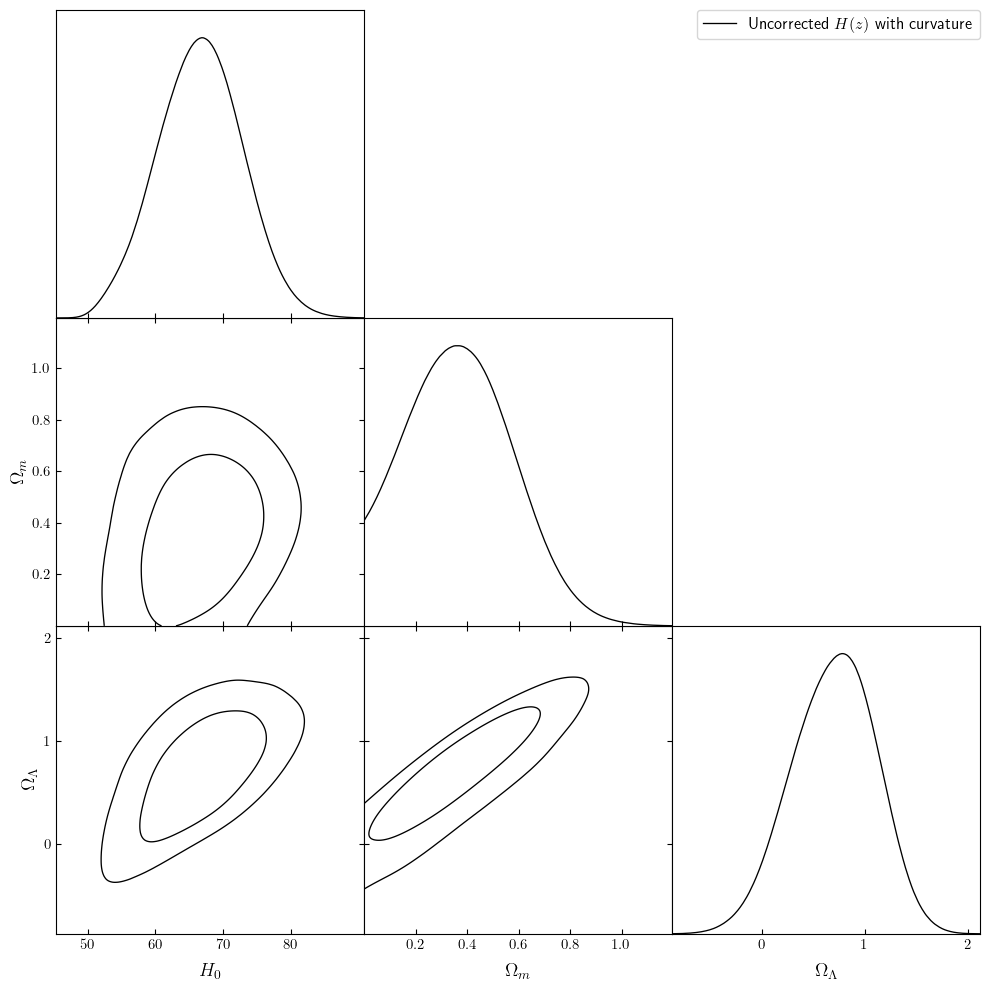

In [12]:
g = plots.getSubplotPlotter(width_inch=10)
g.triangle_plot([gsamplesHzC], filled=False, legend_labels=['Uncorrected $H(z)$ with curvature'])
g.export('fig/g'+prefixC+'All-triangle.pdf')

In [13]:
samplesHzC, gsamplesHzC, parnamesC, ndim = insertDerived(samplesHzC, parnamesC, parlabelsC, 4, gsamplesHzC, 1 - gsamplesHzC.getParams().wm - gsamplesHzC.getParams().wl, 'wk', '\Omega_k')

In [14]:
MC_result(samplesHzC, ndim, parnamesC)

MCMC result:
H0 = 66.60620 +6.24942 -6.36461 (median: 66.65910, ml: 0.00000)
wm = 0.37645 +0.20555 -0.21338 (median: 0.36799, ml: 0.00000)
wl = 0.69908 +0.40889 -0.41759 (median: 0.71678, ml: 0.00000)
wk = -0.07553 +0.61865 -0.59820 (median: -0.08244, ml: 0.00000)


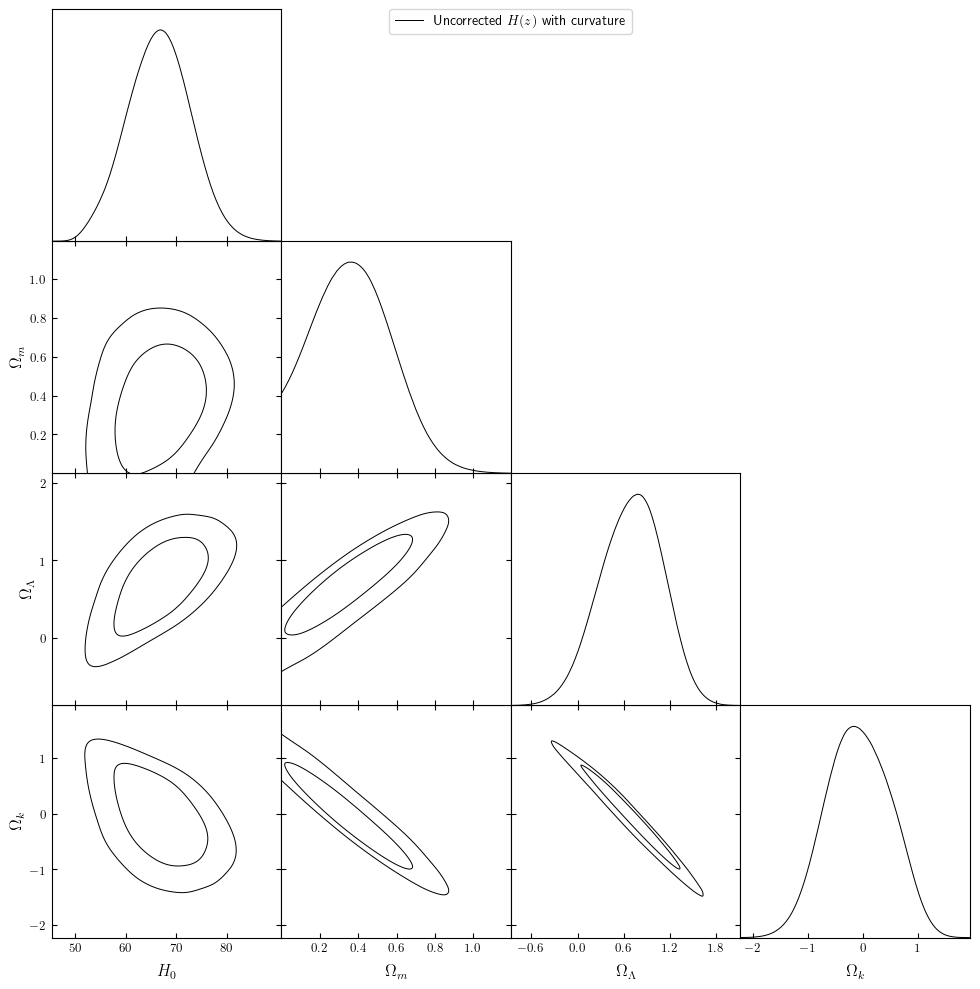

In [15]:
g = plots.getSubplotPlotter(width_inch=10)
g.triangle_plot([gsamplesHzC], filled=False, legend_labels=['Uncorrected $H(z)$ with curvature'])
g.export('fig/g'+prefixC+'All-triangle_Wk.pdf')

In [16]:
for i in range(len(ndim)):
    for j in range(1,4):
        print(gsamplesHzC.getInlineLatex(parnamesC[i],limit=j))
        
print(gsamplesHzC.getTable().tableTex())

H_0 = 66.6\pm 6.2
H_0 = 67^{+10}_{-10}
H_0 = 67^{+20}_{-20}
\Omega_m = 0.38^{+0.19}_{-0.23}
\Omega_m < 0.717
\Omega_m < 0.866
\Omega_\Lambda = 0.70^{+0.44}_{-0.38}
\Omega_\Lambda = 0.70^{+0.74}_{-0.81}
\Omega_\Lambda = 0.70^{+0.94}_{-1.1}
\Omega_k = -0.08\pm 0.58
\Omega_k = -0.1^{+1.1}_{-1.1}
\Omega_k = -0.1^{+1.4}_{-1.4}
\begin{tabular} { l  c}

 Parameter &  95\% limits\\
\hline
{\boldmath$H_0            $} & $67^{+10}_{-10}            $\\

{\boldmath$\Omega_m       $} & $< 0.717                   $\\

{\boldmath$\Omega_\Lambda $} & $0.70^{+0.74}_{-0.81}      $\\

$\Omega_k                  $ & $-0.1^{+1.1}_{-1.1}        $\\
\hline
\end{tabular}


In [17]:
print(types.ResultTable(ncol=1,results=gsamplesHzC, paramList=parnamesC, limit=2).tableTex())

\begin{tabular} { l  c}

 Parameter &  95\% limits\\
\hline
{\boldmath$H_0            $} & $67^{+10}_{-10}            $\\

{\boldmath$\Omega_m       $} & $< 0.717                   $\\

{\boldmath$\Omega_\Lambda $} & $0.70^{+0.74}_{-0.81}      $\\

$\Omega_k                  $ & $-0.1^{+1.1}_{-1.1}        $\\
\hline
\end{tabular}


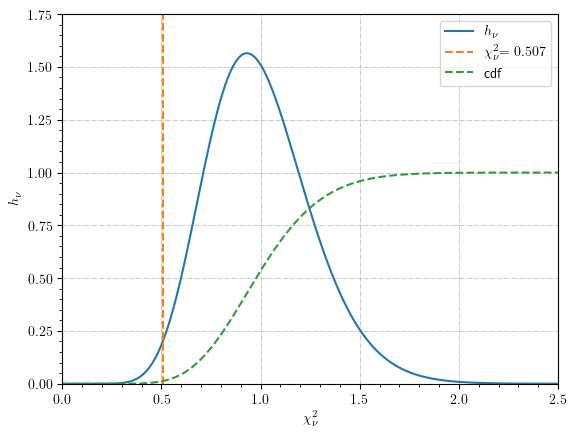

Probabilidade =  1.2711949898080448
Chiv =  0.5065335350094305


In [21]:
chi2mC = chi2Hz(free_par([66.60620, 0.37645, 0.69908], freef=False, flat=False))
chivCperc, errF = quad(chiDist, 0, chi2mC/(ndata-len(par_HzC)), args=(ndata-len(par_HzC)))
plotChiDist(chi2mC, len(par_HzC))
print('Probabilidade = ', chivCperc*100)
print('Chiv = ', chi2mC/(ndata-len(par_HzC)))

# Corrected LCDM with curvature

In [22]:
par_HzCF = [69.1929957609451,0.2480895086492853, 0.6862431649000225, .9]
ndimCF = len(par_HzCF)
prefixCF = 'LcdmHz32Cov'
parlabelsCF = ["H_0","\Omega_m", "\Omega_\Lambda", "f"]
parlabtexCF = ["$H_0$","$\Omega_m$", "$\Omega_\Lambda$", "$f$"]
parnamesCF = ['H0','wm','wl', 'f']

resultHzCF = find_bestfit(lnprobHz, par_HzCF, parnamesCF, freef=True, flat=False)
par_HzCF = resultHzCF['x']

Maximum likelihood result:
H0  =  68.43573467548853
wm  =  0.37467105254039906
wl  =  0.7837200228628217
f  =  0.6725718558132805
chi2min = 6.614634248192143
Total time: 0.014 seg


In [25]:
samplerHzCF = run_emcee(par_HzCF, 100, lnprobHz, True, False, 2.0, nstepHz)

100%|█████████████████████████████████████████████████| 20000/20000 [02:31<00:00, 131.81it/s]

Acceptance fraction: [0.58995 0.58685 0.58125 0.58575 0.5793  0.5853  0.58405 0.5844  0.5897
 0.5849  0.57895 0.5845  0.59155 0.58145 0.582   0.5834  0.5828  0.58375
 0.5848  0.5882  0.58285 0.5838  0.575   0.58305 0.58035 0.58515 0.57695
 0.5852  0.57865 0.58605 0.5851  0.58155 0.5837  0.5855  0.58525 0.58575
 0.5861  0.584   0.57825 0.58475 0.5788  0.5787  0.5876  0.58285 0.58265
 0.5886  0.58105 0.585   0.5811  0.5886  0.5878  0.58035 0.5839  0.58235
 0.5828  0.58315 0.5892  0.58035 0.58345 0.58685 0.58265 0.57485 0.59025
 0.5808  0.5849  0.5824  0.58215 0.58505 0.5871  0.5896  0.57635 0.57525
 0.578   0.58065 0.5886  0.58425 0.5853  0.5876  0.5834  0.5868  0.5794
 0.5847  0.5811  0.59075 0.59085 0.58325 0.58    0.58355 0.58145 0.584
 0.58425 0.58375 0.58295 0.5877  0.58445 0.58145 0.58745 0.58695 0.59175
 0.58015]
Minimum acceptance: 0.57485
Maximum acceptance: 0.59175


In [26]:
tauHzCF = samplerHzCF.get_autocorr_time()
print(tauHzCF)

tauHzmaxCF = np.amax(tauHzCF)
r = nstepHz/tauHzmaxCF
print(r)

if(r>50):
    print('Convergiu! :)')
else:
    print('Não convergiu... :\'(:' )

[49.82505808 49.95244275 50.46673128 49.07029743]
396.3006815016637
Convergiu! :)


In [27]:
samplesHzCF = burninthin(samplerHzCF, 100)

(39600, 4)


In [28]:
MC_result(samplesHzCF, par_HzCF, parnamesCF)

MCMC result:
H0 = 67.16828 +4.71358 -4.70785 (median: 67.25901, ml: 68.43573)
wm = 0.36434 +0.15935 -0.16501 (median: 0.36450, ml: 0.37467)
wl = 0.71192 +0.32021 -0.32660 (median: 0.73167, ml: 0.78372)
f = 0.73771 +0.09891 -0.09899 (median: 0.72693, ml: 0.67257)


In [29]:
gsamplesHzCF = MCSamples(samples=samplesHzCF, names=parnamesCF, labels=parlabelsCF, ranges={'wm':(0, None)})
gsamplesHzCF.updateSettings({'countours': [0.682689492137, 0.954499736104, 0.997300203937]})

Removed no burn in


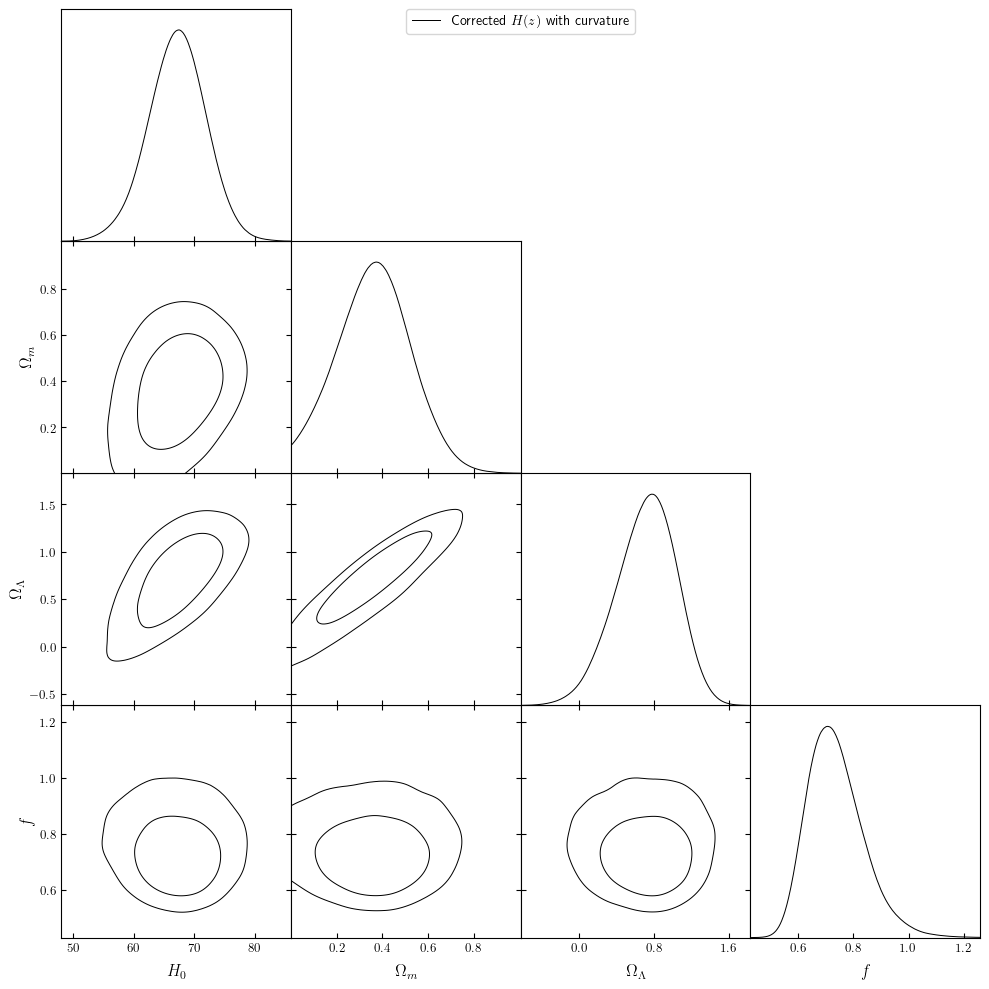

In [30]:
g = plots.getSubplotPlotter(width_inch=10)
g.triangle_plot([gsamplesHzCF], filled=False, legend_labels=['Corrected $H(z)$ with curvature'])
g.export('fig/g'+prefixCF+'All-triangle.pdf')

In [31]:
samplesHzCF, gsamplesHzCF, parnamesCF, ndim = insertDerived(samplesHzCF, parnamesCF, parlabelsCF, 4, gsamplesHzCF, 1 - gsamplesHzCF.getParams().wm - gsamplesHzCF.getParams().wl, 'wk', '\Omega_k')

In [32]:
MC_result(samplesHzCF, ndim, parnamesCF)

MCMC result:
H0 = 67.16828 +4.71358 -4.70785 (median: 67.25901, ml: 0.00000)
wm = 0.36434 +0.15935 -0.16501 (median: 0.36450, ml: 0.00000)
wl = 0.71192 +0.32021 -0.32660 (median: 0.73167, ml: 0.00000)
f = 0.73771 +0.09891 -0.09899 (median: 0.72693, ml: 0.00000)


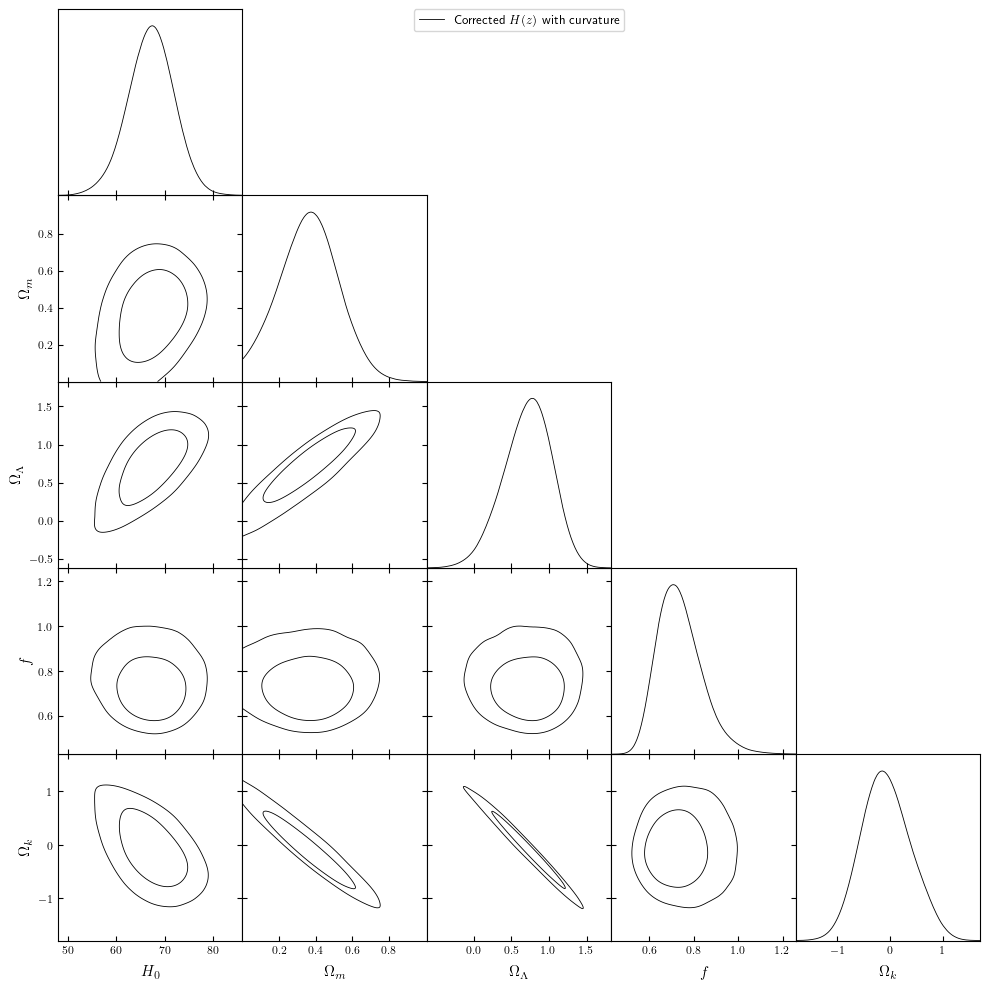

In [33]:
g = plots.getSubplotPlotter(width_inch=10)
g.triangle_plot([gsamplesHzCF], filled=False, legend_labels=['Corrected $H(z)$ with curvature'])
g.export('fig/g'+prefixCF+'All-triangle_Wk.pdf')

In [34]:
for i in range(len(ndim)):
    for j in range(1,4):
        print(gsamplesHzCF.getInlineLatex(parnamesCF[i],limit=j))
        
print(gsamplesHzCF.getTable().tableTex())

H_0 = 67.2\pm 4.8
H_0 = 67^{+9}_{-10}
H_0 = 67^{+10}_{-10}
\Omega_m = 0.36\pm 0.16
\Omega_m = 0.36^{+0.29}_{-0.32}
\Omega_m < 0.739
\Omega_\Lambda = 0.71^{+0.36}_{-0.28}
\Omega_\Lambda = 0.71^{+0.58}_{-0.67}
\Omega_\Lambda = 0.71^{+0.74}_{-0.89}
f = 0.738^{+0.075}_{-0.12}
f = 0.74^{+0.20}_{-0.18}
f = 0.74^{+0.34}_{-0.20}
\begin{tabular} { l  c}

 Parameter &  95\% limits\\
\hline
{\boldmath$H_0            $} & $67^{+9}_{-10}             $\\

{\boldmath$\Omega_m       $} & $0.36^{+0.29}_{-0.32}      $\\

{\boldmath$\Omega_\Lambda $} & $0.71^{+0.58}_{-0.67}      $\\

{\boldmath$f              $} & $0.74^{+0.20}_{-0.18}      $\\

$\Omega_k                  $ & $-0.08^{+0.94}_{-0.87}     $\\
\hline
\end{tabular}


In [35]:
print(types.ResultTable(ncol=1,results=gsamplesHzC, paramList=parnamesC, limit=2).tableTex())

\begin{tabular} { l  c}

 Parameter &  95\% limits\\
\hline
{\boldmath$H_0            $} & $67^{+10}_{-10}            $\\

{\boldmath$\Omega_m       $} & $< 0.717                   $\\

{\boldmath$\Omega_\Lambda $} & $0.70^{+0.74}_{-0.81}      $\\

$\Omega_k                  $ & $-0.1^{+1.1}_{-1.1}        $\\
\hline
\end{tabular}


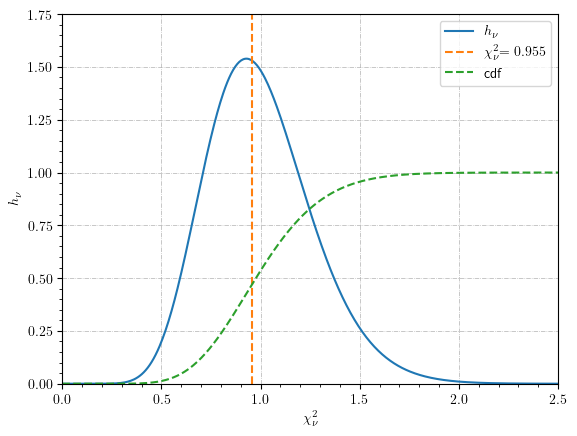

Probabilidade =  46.81143717555001
Chiv =  0.9553601869454954


In [55]:
chi2CF=chi2Hz(free_par([67.16828,0.36434,0.71192,0.73771], freef=True, flat=False))
plotChiDist(chi2CF, len(par_HzCF))
chivCFperc, errF = quad(chiDist, 0, chi2CF/(ndata-len(par_HzCF)), args=(ndata-len(par_HzCF)))
print('Probabilidade = ', chivCFperc*100)
print('Chiv = ', chi2CF/(ndata-len(par_HzCF)))

# Comparison between corrected and uncorrected H(z) with curvature

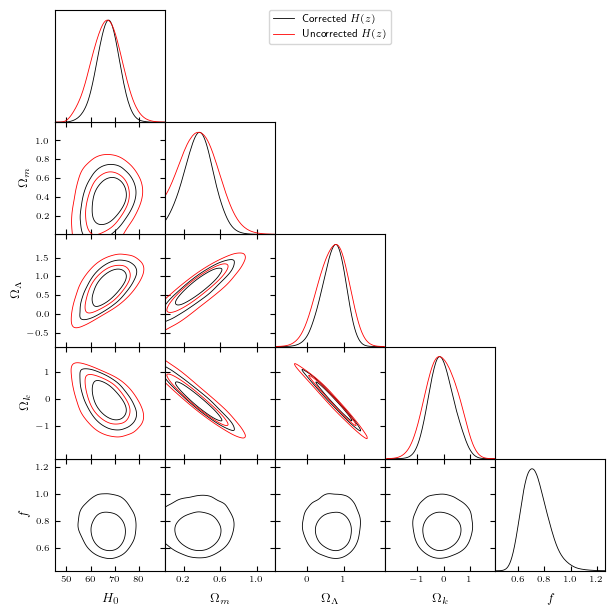

In [38]:
g = plots.getSubplotPlotter(subplot_size=1.25)
g.triangle_plot([gsamplesHzCF, gsamplesHzC], [parnamesCF[0],parnamesCF[1],parnamesCF[2],parnamesCF[4],parnamesCF[3]],filled=False, legend_labels=['Corrected $H(z)$','Uncorrected $H(z)$'])
g.export('fig/gcompUncCorrAll-triangle.pdf')

# Uncorrected Flat LCDM

In [39]:
par_HzF = [69.1929957609451, 0.2480895086492853]
ndimF = len(par_HzF)
prefixF = 'FlatLcdmHz32Cov'
parlabelsF = ["H_0","\Omega_m"]
parlabtexF = ["$H_0$","$\Omega_m$"]
parnamesF = ['H0','wm']

resultHzF = find_bestfit(lnprobHz, par_HzF, parnamesF, freef=False, flat=True)
par_mlHzF = resultHzF['x']

Maximum likelihood result:
H0  =  67.59280729689723
wm  =  0.3227253732283781
chi2min = 14.532604111470516
Total time: 0.016 seg


In [40]:
samplerHzF = run_emcee(par_HzF, 100, lnprobHz, False, True, 2.0, nstepHz)

100%|█████████████████████████████████████████████████| 20000/20000 [02:28<00:00, 134.52it/s]

Acceptance fraction: [0.7152  0.7224  0.7102  0.7142  0.7083  0.7161  0.71005 0.70855 0.7148
 0.7135  0.7064  0.71625 0.71515 0.70535 0.7117  0.7101  0.7139  0.70915
 0.7127  0.71175 0.72075 0.71885 0.70715 0.7072  0.7072  0.7131  0.7098
 0.7156  0.71315 0.71515 0.71445 0.71425 0.7179  0.7161  0.71095 0.71085
 0.71835 0.7208  0.7159  0.70975 0.7085  0.7108  0.719   0.71375 0.7132
 0.71815 0.71305 0.7072  0.7153  0.7149  0.7128  0.71005 0.7098  0.70525
 0.70715 0.7099  0.7121  0.707   0.70765 0.71565 0.71305 0.7098  0.7159
 0.70205 0.71485 0.71465 0.7135  0.70905 0.71055 0.716   0.7062  0.7061
 0.7118  0.7068  0.7076  0.7123  0.7155  0.70845 0.71415 0.71335 0.7078
 0.7107  0.71335 0.71525 0.7076  0.70905 0.7085  0.70795 0.7083  0.7058
 0.7103  0.707   0.71865 0.7126  0.70805 0.71605 0.7131  0.7096  0.7187
 0.71325]
Minimum acceptance: 0.70205
Maximum acceptance: 0.7224


In [41]:
tauHzF = samplerHzF.get_autocorr_time()
print(tauHzF)

tauHzmaxF = np.amax(tauHzF)
r = nstepHz/tauHzmaxF
print(r)

if(r>50):
    print('Convergiu! :)')
else:
    print('Não convergiu... :\'(:' )

[32.48669957 33.36806989]
599.3753928266833
Convergiu! :)


In [42]:
samplesHzF = burninthin(samplerHzF, tauHzF)

(124500, 2)


In [43]:
MC_result(samplesHzF, par_HzF, parnamesF)

MCMC result:
H0 = 66.64526 +5.43961 -5.49322 (median: 66.66642, ml: 69.19300)
wm = 0.34222 +0.07071 -0.07099 (median: 0.33412, ml: 0.24809)


In [45]:
gsamplesHzF = MCSamples(samples=samplesHzF, names=parnamesF, labels=parlabelsF, ranges={'wm':(0, None)})
gsamplesHzF.updateSettings({'countours': [0.682689492137, 0.954499736104, 0.997300203937]})

Removed no burn in


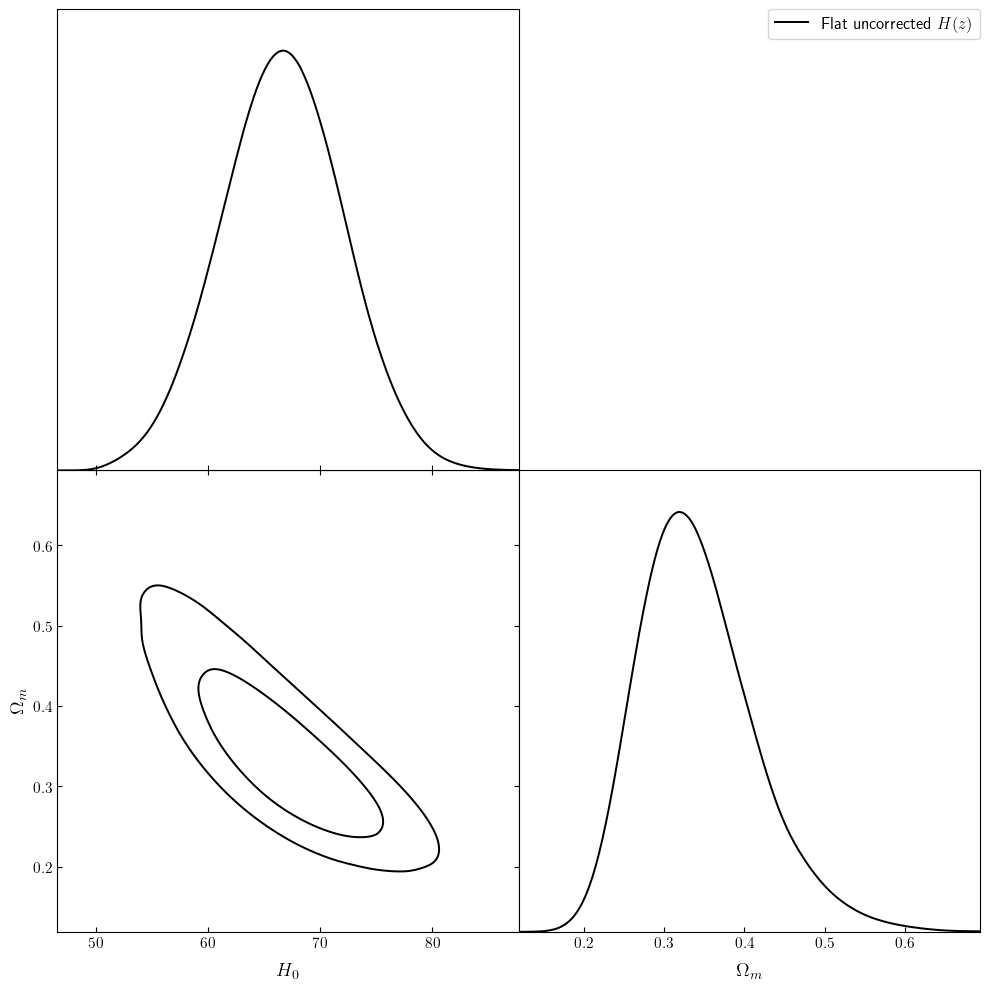

In [46]:
g = plots.getSubplotPlotter(width_inch=10)
g.triangle_plot([gsamplesHzF], filled=False, legend_labels=['Flat uncorrected $H(z)$'])
g.export('fig/g'+prefixF+'All-triangle.pdf')

In [47]:
samplesHzF, gsamplesHzF, parnamesF, ndim = insertDerived(samplesHzF, parnamesF, parlabelsF, 3, gsamplesHzF, 1 - gsamplesHzF.getParams().wm, 'wl', '\Omega _{\Lambda}')

In [48]:
MC_result(samplesHzF, ndim, parnamesF)

MCMC result:
H0 = 66.64526 +5.43961 -5.49322 (median: 66.66642, ml: 0.00000)
wm = 0.34222 +0.07071 -0.07099 (median: 0.33412, ml: 0.00000)
wl = 0.65778 +0.07099 -0.07071 (median: 0.66588, ml: 0.00000)


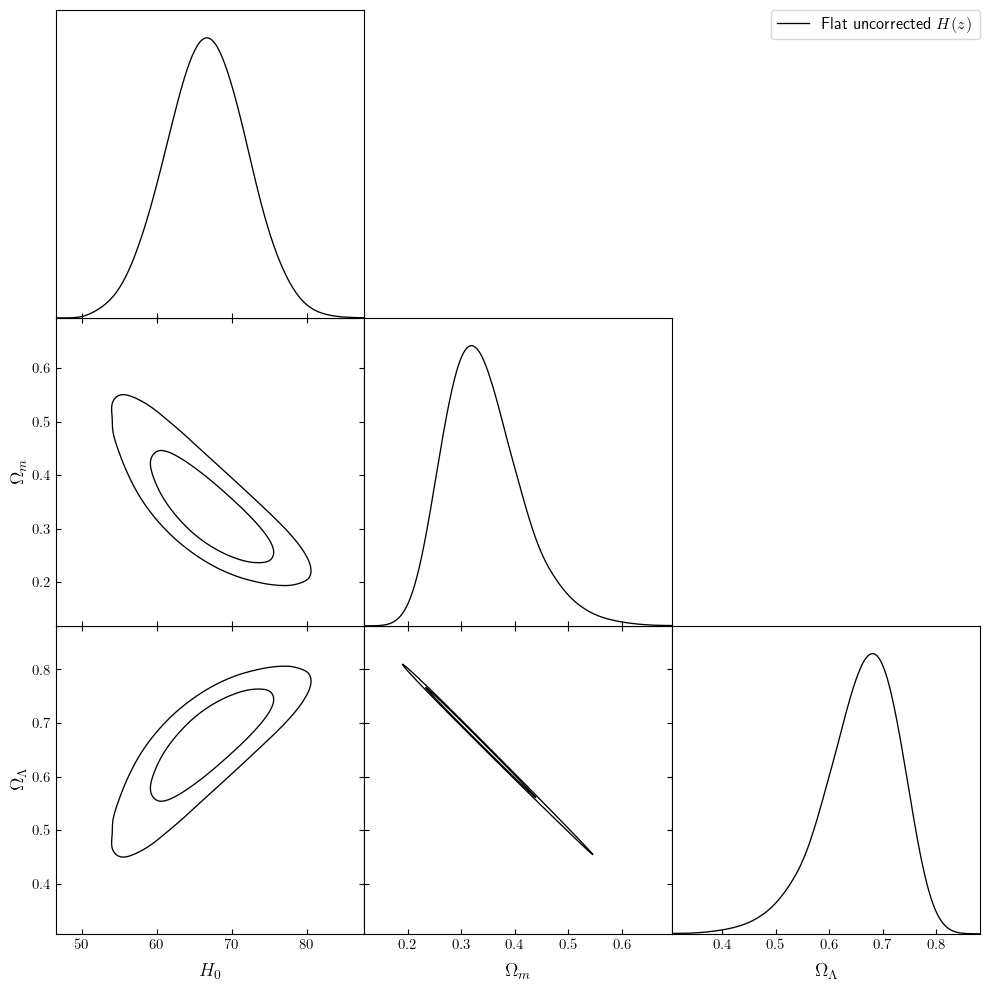

In [49]:
g = plots.getSubplotPlotter(width_inch=10)
g.triangle_plot([gsamplesHzF], filled=False, legend_labels=['Flat uncorrected $H(z)$'])
g.export('fig/g'+prefixF+'All-triangle_Wl.pdf')

In [52]:
for i in range(ndimF+1):
    for j in range(1,4):
        print(gsamplesHzF.getInlineLatex(parnamesF[i],limit=j))
        
print(gsamplesHzF.getTable().tableTex())

H_0 = 66.6\pm 5.4
H_0 = 67^{+10}_{-10}
H_0 = 67^{+10}_{-10}
\Omega_m = 0.342^{+0.054}_{-0.084}
\Omega_m = 0.34^{+0.15}_{-0.13}
\Omega_m = 0.34^{+0.24}_{-0.15}
\Omega _{\Lambda} = 0.658^{+0.084}_{-0.054}
\Omega _{\Lambda} = 0.66^{+0.13}_{-0.15}
\Omega _{\Lambda} = 0.66^{+0.15}_{-0.24}
\begin{tabular} { l  c}

 Parameter &  95\% limits\\
\hline
{\boldmath$H_0            $} & $67^{+10}_{-10}            $\\

{\boldmath$\Omega_m       $} & $0.34^{+0.15}_{-0.13}      $\\

$\Omega _{\Lambda}         $ & $0.66^{+0.13}_{-0.15}      $\\
\hline
\end{tabular}


In [53]:
print(types.ResultTable(ncol=1,results=gsamplesHzF, paramList=parnamesF, limit=2).tableTex())

\begin{tabular} { l  c}

 Parameter &  95\% limits\\
\hline
{\boldmath$H_0            $} & $67^{+10}_{-10}            $\\

{\boldmath$\Omega_m       $} & $0.34^{+0.15}_{-0.13}      $\\

$\Omega _{\Lambda}         $ & $0.66^{+0.13}_{-0.15}      $\\
\hline
\end{tabular}


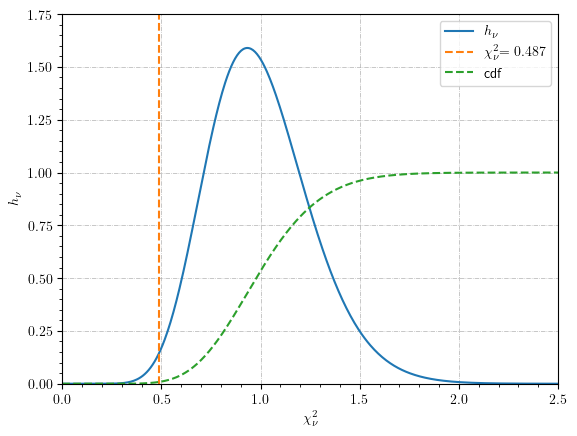

Probabilidade =  0.8288540205558115
Chiv =  0.4873718944729026


In [57]:
chi2F=chi2Hz(free_par([66.64526,0.34222], freef=False, flat=True))
plotChiDist(chi2F, len(par_HzF))
chivFperc, errF = quad(chiDist, 0, chi2F/(ndata-len(par_HzF)), args=(ndata-len(par_HzF)))
print('Probabilidade = ', chivFperc*100)
print('Chiv = ', chi2F/(ndata-len(par_HzF)))

# Corrected Flat LCDM

In [58]:
par_HzFf = [69.1929957609451,0.2480895086492853, .9]
ndimFf = len(par_HzFf)
prefixFf = 'LcdmHz32CovCorr'
parlabelsFf = ['H_0','\Omega_m', 'f']
parlabtexFf = ['$H_0$','$\Omega_m$', '$f$']
parnamesFf = ['H0','wm', 'f']

resultHzFf = find_bestfit(lnprobHz, par_HzFf, parnamesFf, freef=True, flat=True)
par_mlHzFf = resultHzFf['x']

Maximum likelihood result:
H0  =  67.59280626862557
wm  =  0.3227253864221665
f  =  0.6739019670035041
chi2min = 6.741081017985426
Total time: 0.011 seg


In [59]:
samplerHzFf = run_emcee(par_HzFf, 100, lnprobHz, True, True, 2.0, nstepHz)

100%|█████████████████████████████████████████████████| 20000/20000 [02:40<00:00, 124.65it/s]

Acceptance fraction: [0.64655 0.64695 0.63425 0.64195 0.63995 0.64615 0.63865 0.6371  0.64585
 0.63895 0.6333  0.6426  0.6409  0.64065 0.63765 0.6395  0.64575 0.6385
 0.6374  0.6427  0.647   0.6403  0.6329  0.63735 0.6422  0.6418  0.64
 0.6471  0.63715 0.64295 0.6401  0.64295 0.6411  0.6441  0.637   0.6429
 0.64385 0.6459  0.63875 0.63895 0.6333  0.6372  0.64805 0.64575 0.63805
 0.64415 0.6466  0.6388  0.64555 0.6457  0.64575 0.638   0.6462  0.63505
 0.64465 0.64455 0.6405  0.6317  0.6414  0.64255 0.6425  0.63765 0.6382
 0.63105 0.63955 0.64075 0.64235 0.64275 0.63765 0.64455 0.6353  0.639
 0.639   0.6363  0.643   0.63995 0.64875 0.6404  0.64075 0.644   0.6428
 0.63375 0.63815 0.643   0.6444  0.64095 0.6397  0.63675 0.6382  0.6431
 0.63855 0.63925 0.6444  0.6449  0.636   0.6401  0.648   0.6394  0.64295
 0.63825]
Minimum acceptance: 0.63105
Maximum acceptance: 0.64875


In [60]:
tauHzFf = samplerHzFf.get_autocorr_time()
print(tauHzFf)

tauHzmaxFf = np.amax(tauHzFf)
r = nstepHz/tauHzmaxFf
print(r)

if(r>50):
    print('Convergiu! :)')
else:
    print('Não convergiu... :\'(:' )

[40.28424089 40.79987787 39.31957954]
490.19754582032436
Convergiu! :)


In [61]:
samplesHzFf = burninthin(samplerHzFf, tauHzFf)

(104800, 3)


In [62]:
MC_result(samplesHzFf, par_mlHzFf, parnamesFf)

MCMC result:
H0 = 67.10380 +3.88822 -3.92296 (median: 67.15045, ml: 67.59281)
wm = 0.33287 +0.04932 -0.04977 (median: 0.32830, ml: 0.32273)
f = 0.72775 +0.09677 -0.09673 (median: 0.71689, ml: 0.67390)


In [63]:
gsamplesHzFf = MCSamples(samples=samplesHzFf, names=parnamesFf, labels=parlabelsFf, ranges={'wm':(0, None)})
gsamplesHzFf.updateSettings({'countours': [0.682689492137, 0.954499736104, 0.997300203937]})

Removed no burn in


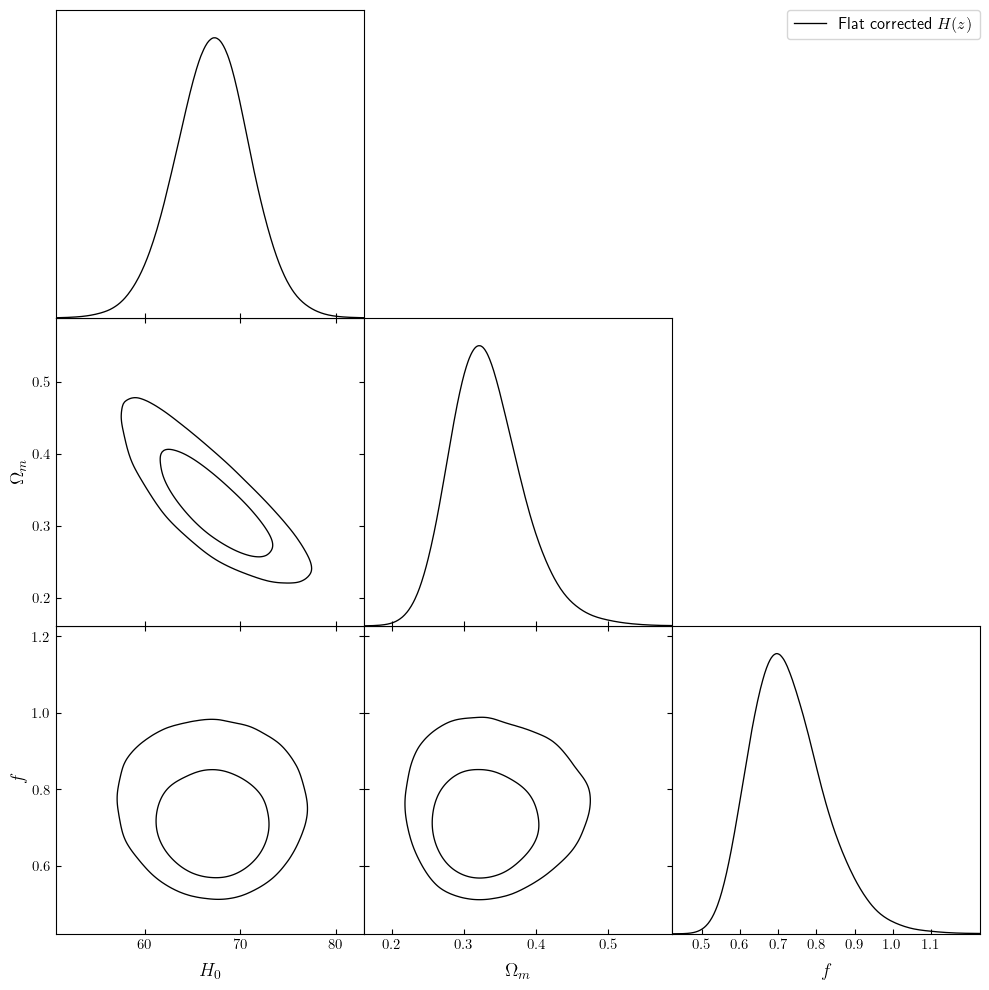

In [64]:
g = plots.getSubplotPlotter(width_inch=10)
g.triangle_plot([gsamplesHzFf], filled=False, legend_labels=['Flat corrected $H(z)$'])
g.export('fig/g'+prefixFf+'All-triangle.pdf')

In [67]:
samplesHzFf, gsamplesHzFf, parnamesFf, ndim = insertDerived(samplesHzFf, parnamesFf, parlabelsFf, 4, gsamplesHzFf, 1 - gsamplesHzFf.getParams().wm, 'wl', '\Omega _{\Lambda}')

Parâmetro dependente já adicionado.


In [68]:
MC_result(samplesHzFf, ndim, parnamesFf)

MCMC result:
H0 = 67.10380 +3.88822 -3.92296 (median: 67.15045, ml: 0.00000)
wm = 0.33287 +0.04932 -0.04977 (median: 0.32830, ml: 0.00000)
f = 0.72775 +0.09677 -0.09673 (median: 0.71689, ml: 0.00000)
wl = 0.66713 +0.04977 -0.04932 (median: 0.67170, ml: 0.00000)


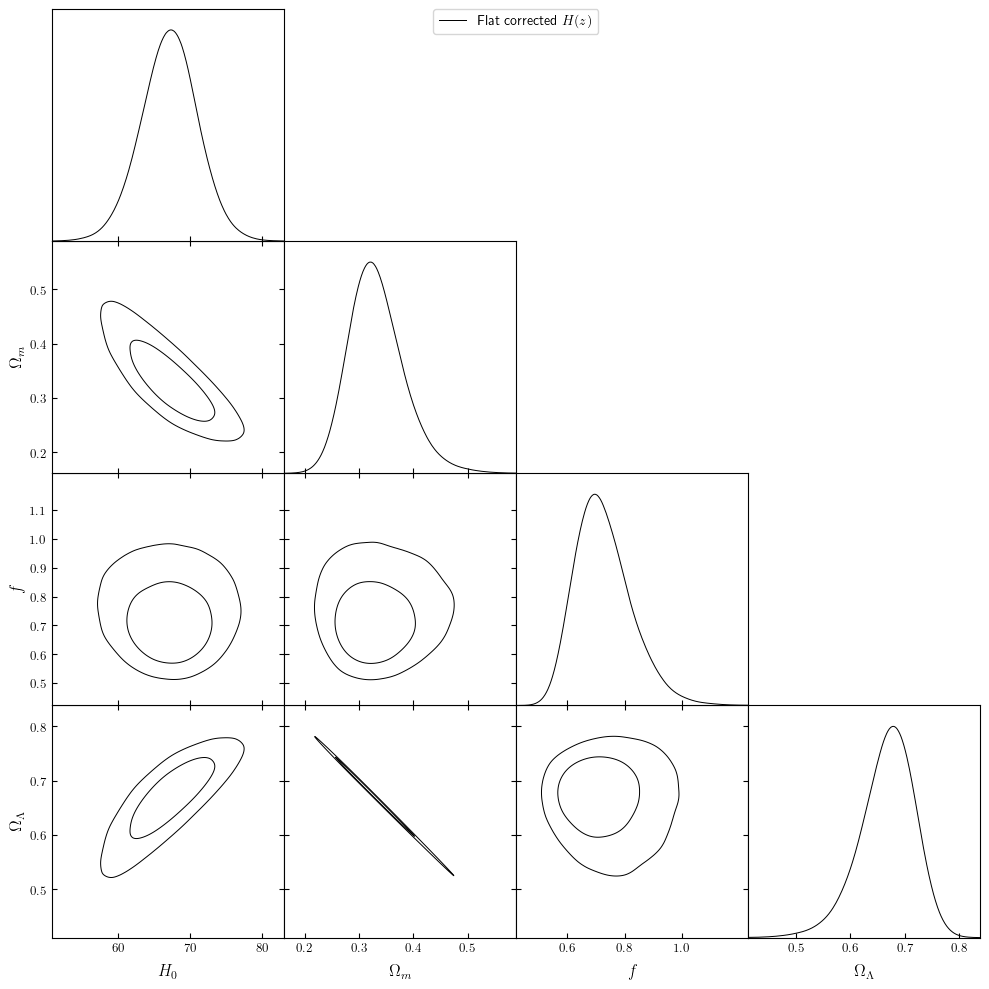

In [69]:
g = plots.getSubplotPlotter(width_inch=10)
g.triangle_plot([gsamplesHzFf], filled=False, legend_labels=['Flat corrected $H(z)$'])
g.export('fig/g'+prefixFf+'All-triangle_Wl.pdf')

In [71]:
for i in range(ndimFf+1):
    for j in range(1,4):
        print(gsamplesHzFf.getInlineLatex(parnamesFf[i],limit=j))
        
print(gsamplesHzFf.getTable().tableTex())

H_0 = 67.1\pm 4.0
H_0 = 67^{+8}_{-8}
H_0 = 67^{+10}_{-10}
\Omega_m = 0.333^{+0.040}_{-0.057}
\Omega_m = 0.333^{+0.10}_{-0.097}
\Omega_m = 0.33^{+0.17}_{-0.11}
f = 0.728^{+0.073}_{-0.11}
f = 0.73^{+0.20}_{-0.18}
f = 0.73^{+0.32}_{-0.20}
\Omega _{\Lambda} = 0.667^{+0.057}_{-0.040}
\Omega _{\Lambda} = 0.667^{+0.097}_{-0.10}
\Omega _{\Lambda} = 0.67^{+0.11}_{-0.17}
\begin{tabular} { l  c}

 Parameter &  95\% limits\\
\hline
{\boldmath$H_0            $} & $67^{+8}_{-8}              $\\

{\boldmath$\Omega_m       $} & $0.333^{+0.10}_{-0.097}    $\\

{\boldmath$f              $} & $0.73^{+0.20}_{-0.18}      $\\

$\Omega _{\Lambda}         $ & $0.667^{+0.097}_{-0.10}    $\\
\hline
\end{tabular}


In [72]:
print(types.ResultTable(ncol=1,results=gsamplesHzFf, paramList=parnamesFf, limit=2).tableTex())

\begin{tabular} { l  c}

 Parameter &  95\% limits\\
\hline
{\boldmath$H_0            $} & $67^{+8}_{-8}              $\\

{\boldmath$\Omega_m       $} & $0.333^{+0.10}_{-0.097}    $\\

{\boldmath$f              $} & $0.73^{+0.20}_{-0.18}      $\\

$\Omega _{\Lambda}         $ & $0.667^{+0.097}_{-0.10}    $\\
\hline
\end{tabular}


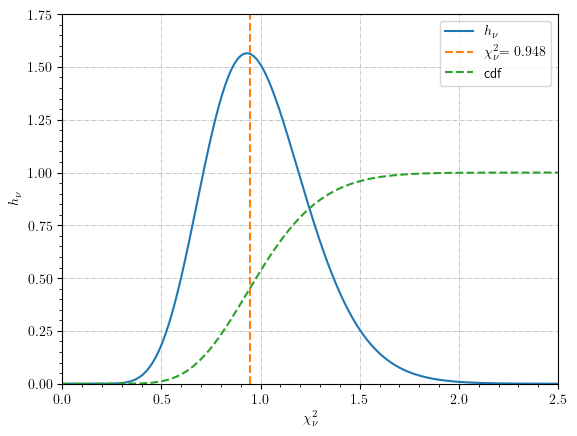

Probabilidade =  45.45382313023643
Chiv =  0.9478187654040636


In [74]:
chi2Ff=chi2Hz(free_par([67.10380,0.33287,0.72775], freef=True, flat=True))
plotChiDist(chi2Ff, len(par_HzFf))
chivFfperc, errF = quad(chiDist, 0, chi2Ff/(ndata-len(par_HzFf)), args=(ndata-len(par_HzFf)))
print('Probabilidade = ', chivFfperc*100)
print('Chiv = ', chi2Ff/(ndata-len(par_HzFf)))

# Comparison between corrected and uncorrected Flat LCDM

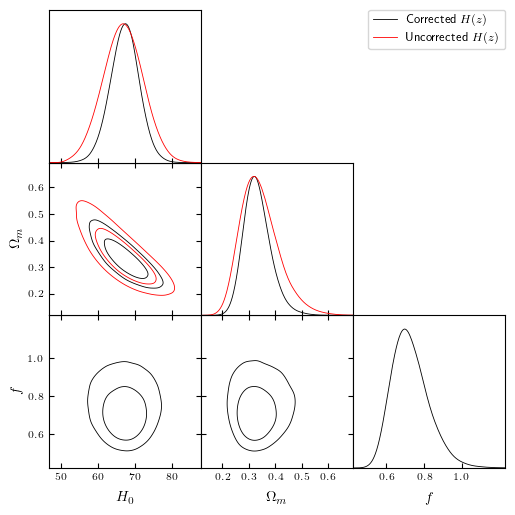

In [75]:
g = plots.getSubplotPlotter(subplot_size=1.75)
g.triangle_plot([gsamplesHzFf, gsamplesHzF], [parnamesFf[0],parnamesFf[1],parnamesFf[2]], filled=False, legend_labels=['Corrected $H(z)$','Uncorrected $H(z)$'])
g.export('fig/gFlatcompUncCorrAll-triangle.pdf')

# Displacement in data no f

In [6]:
#Function to identify which model will be used
def free_parE(theta, freef, flat):
    if freef == True:
        if flat == False:
            h0, wm, wl, f , e= theta
            return [h0, wm, wl, f, e]
        elif flat == True:
            h0, wm, f, e= theta
            return [h0, wm, 1-wm, f, e]
        else:
            print("Invalid flatness...")
            return None
    elif freef == False:
        if flat == False:
            h0, wm, wl, e = theta
            return [h0, wm, wl, 1, e]
        elif flat == True:
            h0, wm, e = theta
            return [h0, wm, 1-wm, 1, e]
        else:
            print("Invalid flatness...")
            return None
    else:
        print("Invalid correction parameter...")
        return None

#Calculate chi2 for the model
def chi2HzE(par):
    E2 = par[1]*(1+zhzi)**3+(1-par[1]-par[2])*(1+zhzi)**2+par[2]

    if np.any(E2<0):
        return np.inf

    Hzm = par[4] + (par[0]-par[4])*np.sqrt(E2)
    dhz = hzi-Hzm
    inv_covCorr = inv_cov/par[3]**2

    return np.dot(np.dot(dhz.T, inv_covCorr), dhz)

#Check if parameters are in prior interval
def lnpriorHzE(par):
    for i in range(len(par)):
        if not priorArrayE[i][0] < par[i] < priorArrayE[i][1]:
            return -np.inf
    return 0.0

#Calculate the likelihood
def lnlikeHzE(par):
    chi2 = chi2HzE(par)
    return -0.5*chi2 - ndata*np.log(par[3])

#?
def lnprobHzE(theta, freef, flat):
    par = free_parE(theta, freef, flat)
    
    lp = lnpriorHzE(par)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlikeHzE(par)

#Minimize chi2
def find_bestfitE(lnlike, par_ml, parnames, freef, flat):
    t1 = time.time()
    ndim = len(par_ml)
    chi2 = lambda par_ml, freef, flat: -2*lnlike(par_ml, freef, flat)
    result = op.minimize(chi2, par_ml, args=(freef, flat))
    if not result['success']:
        result = op.minimize(chi2, par_ml, args=(freef, flat), method='Nelder-Mead', options={'maxiter': 10000})
    par_ml = result['x']
    print('Maximum likelihood result:')
    for i in range(ndim):
        print(parnames[i],' = ',par_ml[i])
    print('chi2min =',result['fun'])
    t2 = time.time()
    print('Total time: {0:5.3f} seg'.format(t2-t1))
    return result

priorArrayE = np.array([[50., 100.], [0.0, 3.0], [-3.0, 3.0], [0.1, 2], [-50,50]])

## Flat LCDM without factor f

In [7]:
par_HzE = [69.1929957609451,0.2480895086492853, 5.]
ndimE = len(par_HzE)
prefixE = 'LcdmHz32CovCorr'
parlabelsE = ['H_0','\Omega_m', '\epsilon']
parlabtexE = ['$H_0$','$\Omega_m$', '$\epsilon$']
parnamesE = ['H0','wm', 'e']

resultHzE = find_bestfit(lnprobHzE, par_HzE, parnamesE, freef=False, flat=True)
par_mlHzE = resultHzE['x']

Maximum likelihood result:
H0  =  67.9220083868301
wm  =  0.2585418562386453
e  =  -11.53060862031493
chi2min = 14.509563170806942
Total time: 0.063 seg


In [8]:
samplerHzE = run_emcee(par_HzE, 100, lnprobHzE, False, True, 2.0, nstepHz)

100%|█████████████████████████████████████████████████| 20000/20000 [02:21<00:00, 141.17it/s]

Acceptance fraction: [0.39325 0.40275 0.39785 0.399   0.3854  0.39785 0.39735 0.40595 0.4065
 0.39505 0.3848  0.4063  0.40035 0.39355 0.39725 0.3942  0.39025 0.3948
 0.3877  0.4004  0.41205 0.39695 0.3993  0.40245 0.39385 0.40385 0.3796
 0.40155 0.3982  0.40015 0.40525 0.4025  0.3938  0.3899  0.39715 0.3991
 0.40005 0.3906  0.40125 0.3907  0.3966  0.38385 0.40445 0.37815 0.39945
 0.3913  0.3871  0.3959  0.39235 0.3945  0.3988  0.38445 0.41215 0.40255
 0.39125 0.40455 0.4091  0.37485 0.3825  0.40145 0.39705 0.3818  0.3881
 0.3947  0.39915 0.3885  0.40275 0.39105 0.3947  0.405   0.37905 0.39385
 0.3996  0.40885 0.40145 0.38985 0.3878  0.39505 0.39105 0.39925 0.38525
 0.39725 0.39465 0.381   0.40635 0.38565 0.38925 0.37645 0.3953  0.39315
 0.4023  0.409   0.3897  0.4115  0.4058  0.408   0.40375 0.40125 0.39465
 0.4017 ]
Minimum acceptance: 0.37485
Maximum acceptance: 0.41215


In [9]:
tauHzE = samplerHzE.get_autocorr_time()
print(tauHzE)

tauHzmaxE = np.amax(tauHzE)
r = nstepHz/tauHzmaxE
print(r)

if(r>50):
    print('Convergiu! :)')
else:
    print('Não convergiu... :\'(:' )

[120.58328604 282.50559371 272.24657534]
70.79505838258791
Convergiu! :)


In [10]:
samplesHzE = burninthin(samplerHzE, tauHzE)

(32300, 3)


In [11]:
MC_result(samplesHzE, par_mlHzE, parnamesE)

MCMC result:
H0 = 65.69300 +5.49755 -5.57234 (median: 65.68213, ml: 67.92201)
wm = 0.91416 +0.83511 -0.66130 (median: 0.64692, ml: 0.25854)
e = 16.40624 +24.24818 -29.36035 (median: 23.56678, ml: -11.53061)


In [12]:
gsamplesHzE = MCSamples(samples=samplesHzE, names=parnamesE, labels=parlabelsE, ranges={'wm':(0, None)})
gsamplesHzE.updateSettings({'countours': [0.682689492137, 0.954499736104, 0.997300203937]})

Removed no burn in


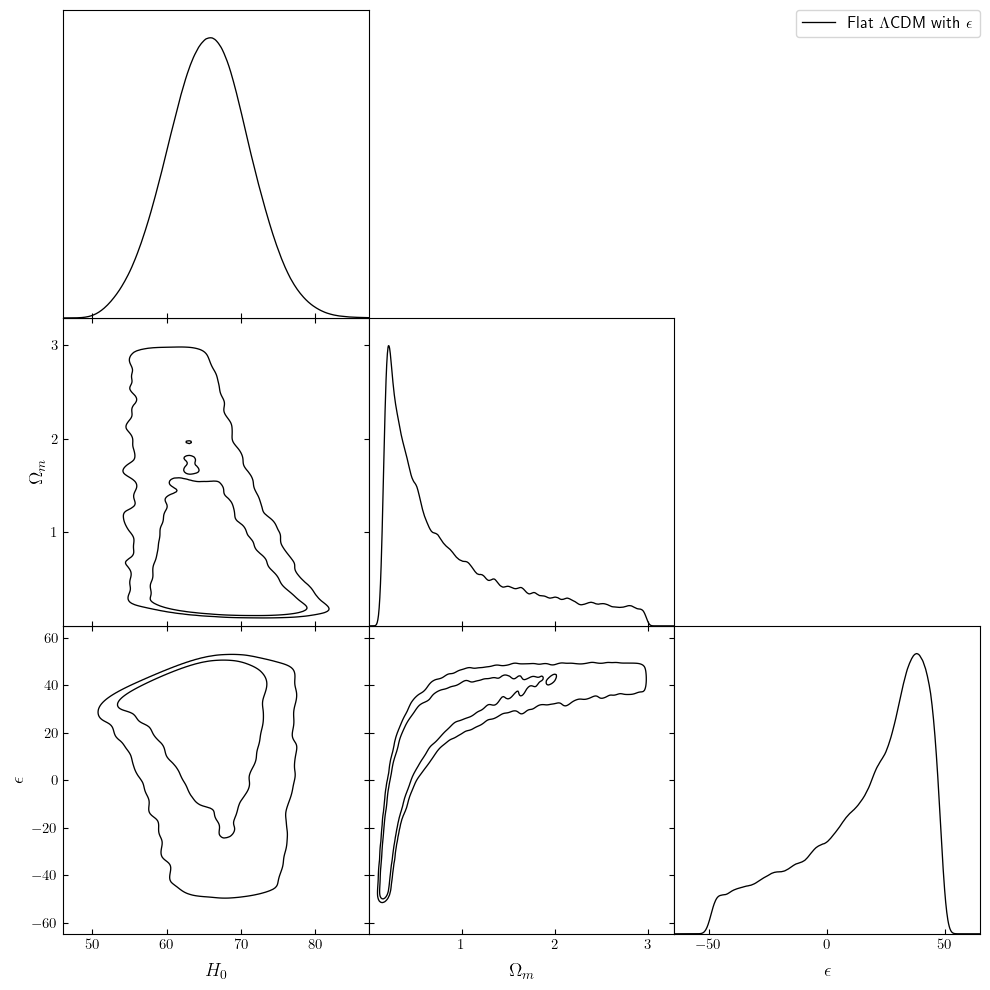

In [13]:
g = plots.getSubplotPlotter(width_inch=10)
g.triangle_plot([gsamplesHzE], filled=False, legend_labels=['Flat $\Lambda$CDM with $\epsilon$'])
#g.export('fig/g'+prefix0+'All-triangle.pdf')

In [14]:
samplesHzE, gsamplesHzE, parnamesE, ndim = insertDerived(samplesHzE, parnamesE, parlabelsE, 4, gsamplesHzE, 1 - gsamplesHzE.getParams().wm, 'wl', '\Omega_l')

In [15]:
MC_result(samplesHzE, ndim, parnamesE)

MCMC result:
H0 = 65.69300 +5.49755 -5.57234 (median: 65.68213, ml: 0.00000)
wm = 0.91416 +0.83511 -0.66130 (median: 0.64692, ml: 0.00000)
e = 16.40624 +24.24818 -29.36035 (median: 23.56678, ml: 0.00000)
wl = 0.08584 +0.66130 -0.83511 (median: 0.35308, ml: 0.00000)


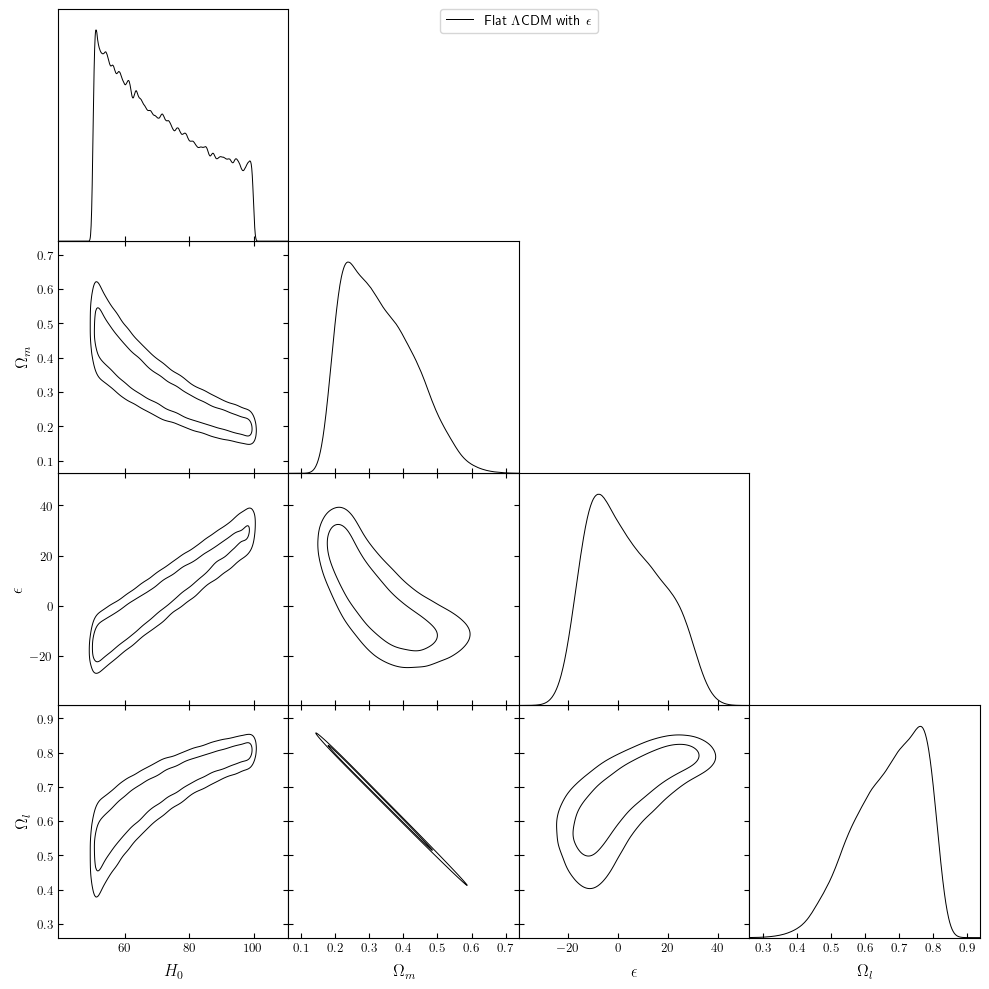

In [101]:
g = plots.getSubplotPlotter(width_inch=10)
g.triangle_plot([gsamplesHzE], filled=False, legend_labels=['Flat $\Lambda$CDM with $\epsilon$'])
#g.export('fig/g'+prefixE+'All-triangle_Wk.pdf')

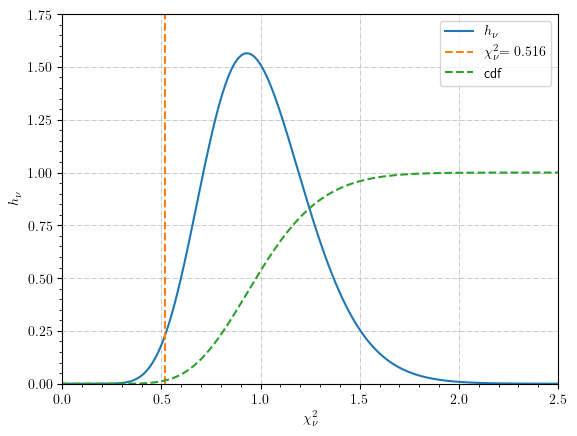

Probabilidade =  1.4694472417728246
Chiv =  0.5159456755856396


In [102]:
chi2E=chi2HzE(free_parE([70.60362,0.32969,3.18051], freef=False, flat=True))
plotChiDist(chi2E, len(par_HzE))
chivEperc, errF = quad(chiDist, 0, chi2E/(ndata-len(par_HzE)), args=(ndata-len(par_HzE)))
print('Probabilidade = ', chivEperc*100)
print('Chiv = ', chi2E/(ndata-len(par_HzE)))

## Flat LCDM with factor f

In [103]:
par_HzEf = [69.1929957609451,0.2480895086492853,.9, 5.]
ndimEf = len(par_HzEf)
prefixEf = 'LcdmHz32CovCorr'
parlabelsEf = ['H_0','\Omega_m', 'f', '\epsilon']
parlabtexEf = ['$H_0$','$\Omega_m$', 'f', '$\epsilon$']
parnamesEf = ['H0','wm', 'f','e']

resultHzEf = find_bestfit(lnprobHzE, par_HzEf, parnamesEf, freef=True, flat=True)
par_mlHzEf = resultHzEf['x']

Maximum likelihood result:
H0  =  79.45291761353093
wm  =  0.25854053254332826
f  =  0.6733675731182021
e  =  11.530901630691037
chi2min = 6.690305864114883
Total time: 0.060 seg


In [105]:
samplerHzEf = run_emcee(par_HzEf, 100, lnprobHzE, True, True, 2.0, nstepHz)

100%|█████████████████████████████████████████████████| 20000/20000 [02:23<00:00, 139.22it/s]

Acceptance fraction: [0.51145 0.51515 0.5103  0.51115 0.51355 0.51265 0.51475 0.5171  0.51555
 0.5128  0.50695 0.519   0.5203  0.5198  0.51355 0.5058  0.5169  0.51025
 0.51785 0.5169  0.5267  0.51765 0.5105  0.5101  0.5122  0.5203  0.5088
 0.52115 0.50825 0.51695 0.51965 0.50765 0.50995 0.5122  0.52    0.5193
 0.5234  0.5157  0.5147  0.51655 0.50335 0.5191  0.52065 0.5228  0.5204
 0.51965 0.5044  0.516   0.52155 0.5193  0.51265 0.52315 0.5266  0.5197
 0.5276  0.52155 0.51825 0.4931  0.51405 0.51095 0.51315 0.5074  0.52195
 0.51625 0.51905 0.5159  0.5205  0.50695 0.5151  0.5161  0.5116  0.50955
 0.5102  0.52305 0.51925 0.50995 0.5194  0.51535 0.5178  0.51785 0.51895
 0.5081  0.5125  0.5176  0.52145 0.52285 0.5145  0.50605 0.519   0.51435
 0.52145 0.51605 0.5182  0.5175  0.51325 0.51    0.52205 0.51385 0.5188
 0.521  ]
Minimum acceptance: 0.4931
Maximum acceptance: 0.5276


In [106]:
tauHzEf = samplerHzEf.get_autocorr_time()
print(tauHzEf)

tauHzmaxEf = np.amax(tauHzEf)
r = nstepHz/tauHzmaxEf
print(r)

if(r>50):
    print('Convergiu! :)')
else:
    print('Não convergiu... :\'(:' )

[97.83416419 98.28188611 60.71253815 93.94057294]
203.49629816390467
Convergiu! :)


In [107]:
samplesHzEf = burninthin(samplerHzEf, tauHzEf)

(66000, 4)


In [108]:
MC_result(samplesHzEf, par_mlHzEf, parnamesEf)

MCMC result:
H0 = 71.28834 +17.24834 -15.81606 (median: 69.49670, ml: 79.45292)
wm = 0.32342 +0.10583 -0.10037 (median: 0.31076, ml: 0.25854)
f = 0.72746 +0.09590 -0.09601 (median: 0.71675, ml: 0.67337)
e = 3.75071 +16.88225 -15.29471 (median: 2.06575, ml: 11.53090)


In [109]:
gsamplesHzEf = MCSamples(samples=samplesHzEf, names=parnamesEf, labels=parlabelsEf, ranges={'wm':(0, None)})
gsamplesHzEf.updateSettings({'countours': [0.682689492137, 0.954499736104, 0.997300203937]})

Removed no burn in


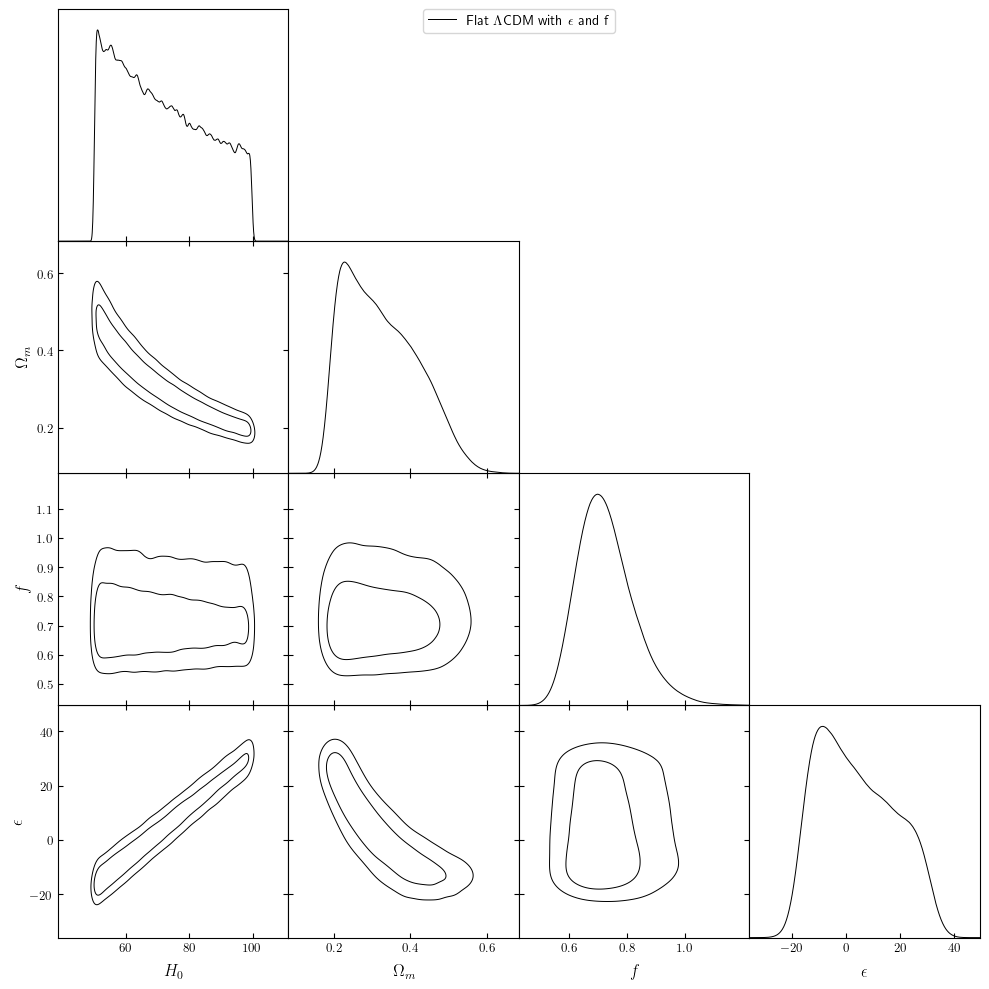

In [110]:
g = plots.getSubplotPlotter(width_inch=10)
g.triangle_plot([gsamplesHzEf], filled=False, legend_labels=['Flat $\Lambda$CDM with $\epsilon$ and f'])
#g.export('fig/g'+prefix0+'All-triangle.pdf')

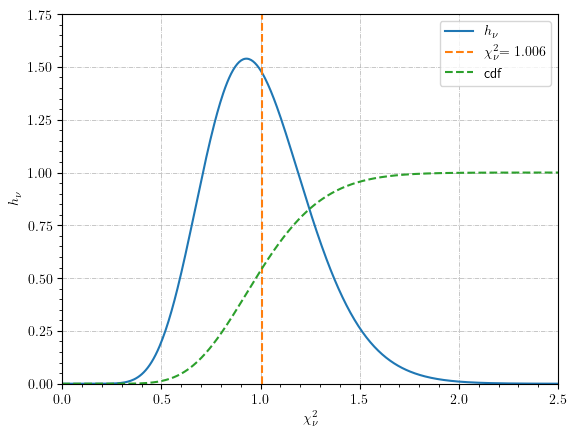

Probabilidade =  1.4694472417728246
Chiv =  1.005982519258645


In [112]:
chi2Ef = chi2HzE(free_parE([71.28834, 0.32342, 0.72746, 3.75071], freef=True, flat=True))
plotChiDist(chi2Ef, len(par_HzEf))
chivEfperc, errF = quad(chiDist, 0, chi2Ef/(ndata-len(par_HzEf)), args=(ndata-len(par_HzEf)))
print('Probabilidade = ', chivEperc*100)
print('Chiv = ', chi2Ef/(ndata-len(par_HzEf)))

## OLCDM without factor f

In [9]:
par_HzCE = [69.1929957609451,0.2480895086492853, 0.6862431649000225, 5.]
ndimCE = len(par_HzCE)
prefixCE = 'LcdmHz32CovCorr'
parlabelsCE = ['H_0','\Omega_m', '\Omega_l', '\epsilon']
parlabtexCE = ['$H_0$','$\Omega_m$', '$\Omega _{\Lambda}', '$\epsilon$']
parnamesCE = ['H0','wm', 'wl', 'e']

resultHzCE = find_bestfitE(lnprobHzE, par_HzCE, parnamesCE, freef=False, flat=False)
par_mlHzCE = resultHzCE['x']

Maximum likelihood result:
H0  =  50.00000023099107
wm  =  0.7081260650738845
wl  =  0.8793043463094492
e  =  -19.042663780818117
chi2min = 14.418428686542548
Total time: 0.112 seg


c:\users\nicol\appdata\local\programs\python\python39\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
c:\users\nicol\appdata\local\programs\python\python39\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
c:\users\nicol\appdata\local\programs\python\python39\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


## OLCDM with factor f

In [10]:
par_HzCEf = [69.1929957609451,0.2480895086492853, 0.6862431649000225, .9, 5.]
ndimCEf = len(par_HzCEf)
prefixCEf = 'LcdmHz32CovCorr'
parlabelsCEf = ['H_0','\Omega_m', '\Omega_l', 'f' '\epsilon']
parlabtexCEf = ['$H_0$','$\Omega_m$', '$\Omega _{\Lambda}', '$\epsilon$', '$\epsilon$']
parnamesCEf = ['H0','wm', 'wl', 'f', 'e']

resultHzCEf = find_bestfitE(lnprobHzE, par_HzCEf, parnamesCEf, freef=True, flat=False)
par_mlHzCEf = resultHzCEf['x']

Maximum likelihood result:
H0  =  50.00000026559206
wm  =  0.7001577642093626
wl  =  0.865120187570845
f  =  0.6722600930384122
e  =  -19.031636430335148
chi2min = 6.490366910571851
Total time: 0.155 seg


c:\users\nicol\appdata\local\programs\python\python39\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
c:\users\nicol\appdata\local\programs\python\python39\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
c:\users\nicol\appdata\local\programs\python\python39\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
c:\users\nicol\appdata\local\programs\python\python39\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
